Note: For analyzing trends and general properties, there is no need to separate the training set from the dev set and test set. Therefore all three dataframes are concatenated together.

In [5]:
# Import packages. Install corresponding packages if you haven't already.
from statsmodels.tsa.seasonal import seasonal_decompose
from ipywidgets import widgets, interactive
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import textstat
from dtw import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from matplotlib.dates import DateFormatter
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [6]:
# Load all three dataframes, and concatenate them together.
df_train = pd.read_csv('../assets/df_train_full_info.csv')
df_dev = pd.read_csv('../assets/df_dev_full_info.csv')
df_test = pd.read_csv('../assets/df_test_full_info.csv')
df = pd.concat([df_train,df_dev,df_test])
df['created_at'] = pd.to_datetime(df['created_at'])

In [7]:
# Take a look at all the disasters.
df.groupby(by=['place','disaster','year']).agg({'id':'count'}).rename(columns={'id':'Tweet Count'}).reset_index()

,place,disaster,year,Tweet Count
0,california,wildfires,2018,4617
1,canada,wildfires,2016,1474
2,dorian(us+caribbean+bamahas),hurricane,2019,5290
3,ecuador,earthquake,2016,981
4,florence(us+cape_verde+bermuda),hurricane,2018,4388
5,harvey(us+caribbean+latin_america),hurricane,2017,6122
6,idai(Africa),cyclone,2019,3061
7,irma(us+caribbean),hurricane,2017,6368
8,italy,earthquake,2016,728
9,kaikoura(new_zealand),earthquake,2016,1443


In [8]:
# Let's first focus on Hurricane Harvey. It has the most tweets, and it's in the largest disaster category (hurricane).
# Focus first on the subset where this tweet can still be retrieved successfully by Apr 24, 2021.
df_harvey = df[df['place'].str.startswith('harvey')]
df_harvey_successful = df_harvey[df_harvey['Response-Code']=='Successful']

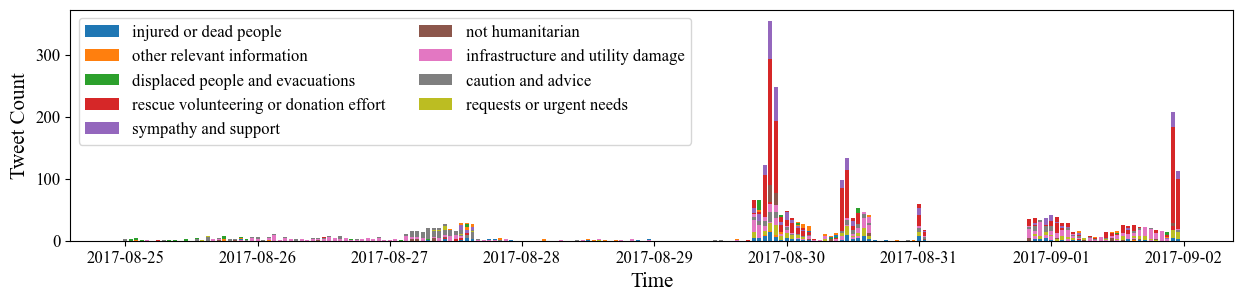

In [71]:
# Trends of Harvey-related tweets.
df_harvey_successful_reset_index = df_harvey_successful.set_index('created_at')
df_harvey_agg = df_harvey_successful_reset_index.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
class_list = df_harvey_successful['class_label'].unique()
figure,ax = plt.subplots(figsize=(15,3))
agg_class_past = [0]*df_harvey_agg.shape[0]
for class_label in class_list:
    df_class = df_harvey_successful_reset_index[df_harvey_successful_reset_index['class_label']==class_label]
    df_class_agg = df_class.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Class Count'})
    df_class_agg = pd.merge(df_harvey_agg,df_class_agg,how='left',left_index=True,right_index=True).fillna(0)
    ax.bar(df_class_agg.index, df_class_agg['Tweet Class Count'], width=0.03, bottom=agg_class_past,label=class_label.replace('_',' '))
    agg_class_past=df_class_agg['Tweet Class Count']
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Tweet Count',fontsize=15)
plt.legend(ncol=2)

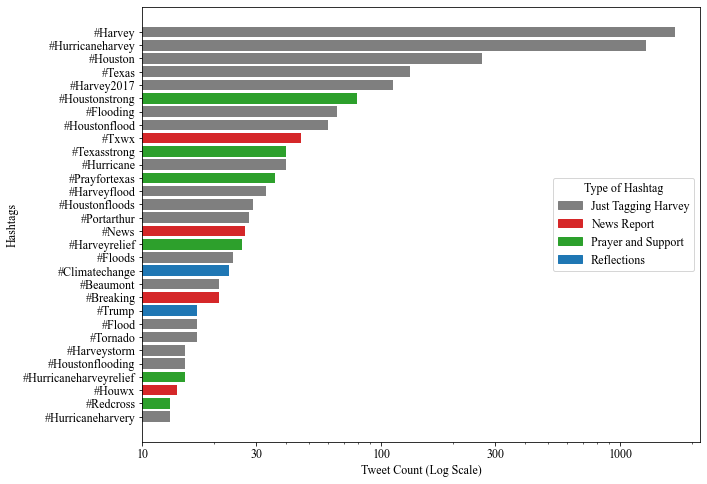

In [8]:
# What are the hottest topics those tweeters care about?
# We will observe the use of hashtags here. Some patterns can be easily observed from the visualization...
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
df_harvey_successful_reset_index['hashtags'] = df_harvey_successful_reset_index['entities'].map(lambda x:eval(x)['hashtags'])
df_hashtag_harvey = df_harvey_successful_reset_index.explode('hashtags').dropna(subset=['hashtags'])
df_hashtag_harvey['hashtags'] = df_hashtag_harvey['hashtags'].map(lambda x:x['text'][0].upper()+x['text'].lower()[1:])
df_hashtag_harvey_agg = df_hashtag_harvey.groupby(by='hashtags').agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
df_hashtag_harvey_agg = df_hashtag_harvey_agg.sort_values(by='Tweet Count',ascending=False).head(30)

# Decide the "types" of hashtag (hard-coded)
label = np.zeros(30,)
type_prayer_and_support=[5,9,11,16,26,28]
type_news=[8,15,20,27]
type_reflections=[18,21]
for i in type_prayer_and_support:
    label[i]=0.25
for i in type_news:
    label[i]=0.5
for i in type_reflections:
    label[i]=1


clist = [(0, "#7f7f7f"),  (0.25, "#2ca02c"),(0.5,"#d62728"),(1,"#1f77b4")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
import matplotlib.ticker as ticker
fig,ax = plt.subplots(figsize=(10,8))
ax.barh(['#'+i for i in df_hashtag_harvey_agg.index[::-1]],df_hashtag_harvey_agg['Tweet Count'][::-1],color=rvb(label[::-1]))
ax.set_xscale('log')
ax.set_ylabel('Hashtags')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.set_xticks([10,30,100,300,1000])
ax.set_xlabel('Tweet Count (Log Scale)')
red_patch = mpatches.Patch(color='#d62728', label='News Report')
gray_patch = mpatches.Patch(color='#7f7f7f', label='Just Tagging Harvey')
green_patch = mpatches.Patch(color='#2ca02c', label='Prayer and Support')
blue_patch = mpatches.Patch(color="#1f77b4", label='Reflections')
plt.legend(handles=[gray_patch,red_patch,green_patch,blue_patch],title='Type of Hashtag',loc='right')

In [9]:
# We will see how the number of each "type" of tweets (except for "Stating Harvey") changes with time.
list_hashtag = [i.lower() for i in list(df_hashtag_harvey_agg.index)]
list_hashtag_prayer_support = [list_hashtag[i] for i in type_prayer_and_support]
list_hashtag_reflections = [list_hashtag[i] for i in type_reflections]
list_hashtag_news = [list_hashtag[i] for i in type_news]
df_harvey_successful_reset_index['hashtags'] = df_harvey_successful_reset_index['hashtags'].map(lambda x:[i['text'].lower() for i in x])

df_hash=df_harvey_successful_reset_index.copy()

def contain(x,lists):
    return bool(set(x).intersection(set(lists)))

df_hash['prayer_support'] = df_hash['hashtags'].apply(lambda x:contain(x,list_hashtag_prayer_support))
df_hash['news'] = df_hash['hashtags'].apply(lambda x:contain(x,list_hashtag_news))
df_hash['reflections'] = df_hash['hashtags'].apply(lambda x:contain(x,list_hashtag_reflections))

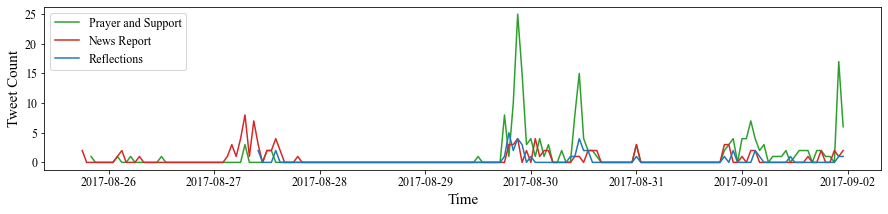

In [10]:
fig,ax=plt.subplots(figsize=(15,3))
df_prayer = df_hash[df_hash['prayer_support']==True].groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
df_news = df_hash[df_hash['news']==True].groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
df_reflections = df_hash[df_hash['reflections']==True].groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})

ax.plot(df_prayer.index,df_prayer['Tweet Count'],label='Prayer and Support',color="#2ca02c")
ax.plot(df_news.index,df_news['Tweet Count'],label='News Report',color="#d62728")
ax.plot(df_reflections.index,df_reflections['Tweet Count'],label='Reflections',color="#1f77b4")
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Tweet Count',fontsize=15)
plt.legend()

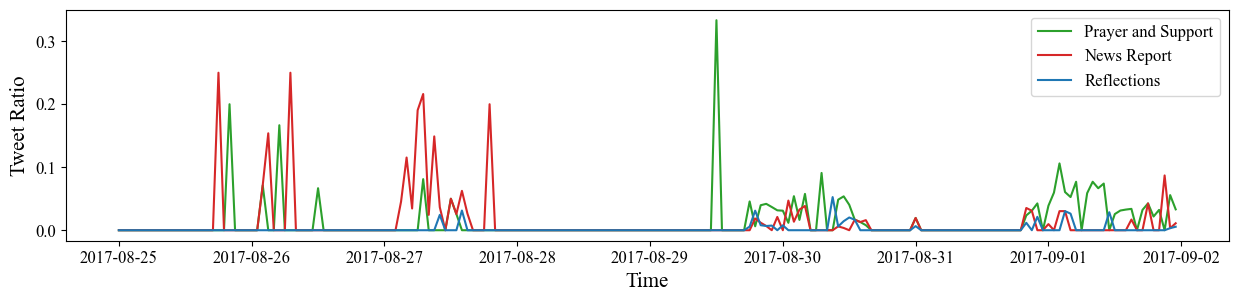

In [53]:
fig,ax=plt.subplots(figsize=(15,3))
df_harvey_agg = df_harvey_agg.rename(columns={'Tweet Count':'Total Tweet Count'})
df_prayer_ratio = df_harvey_agg.merge(df_prayer,left_index=True,right_index=True,how='left').fillna(0)
df_prayer_ratio['ratio'] = df_prayer_ratio['Tweet Count']/df_prayer_ratio['Total Tweet Count']
df_prayer_ratio=df_prayer_ratio.fillna(0)
df_news_ratio = df_harvey_agg.merge(df_news,left_index=True,right_index=True,how='left').fillna(0)
df_news_ratio['ratio'] = df_news_ratio['Tweet Count']/df_news_ratio['Total Tweet Count']
df_news_ratio=df_news_ratio.fillna(0)
df_reflections_ratio = df_harvey_agg.merge(df_reflections,left_index=True,right_index=True,how='left').fillna(0)
df_reflections_ratio['ratio'] = df_reflections_ratio['Tweet Count']/df_reflections_ratio['Total Tweet Count']
df_reflections_ratio=df_reflections_ratio.fillna(0)
ax.plot(df_prayer_ratio.index,df_prayer_ratio['ratio'],label='Prayer and Support',color="#2ca02c")
ax.plot(df_news_ratio.index,df_news_ratio['ratio'],label='News Report',color="#d62728")
ax.plot(df_reflections_ratio.index,df_reflections_ratio['ratio'],label='Reflections',color="#1f77b4")
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Tweet Ratio',fontsize=15)
plt.legend()

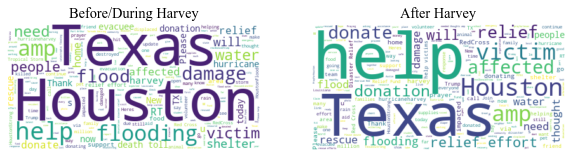

In [11]:
# What exactly happened before and after harvey (especially when tweets peaked)?
# Note: Removed keywords "Hurricane" and "Harvey" from the corpus; 
# they do not really contribute to understanding the context.
hottest_list = list(df_harvey_successful[(df_harvey_successful['created_at']>=pd.to_datetime('2017-08-29 21:00:00+00:00')) & (df_harvey_successful['created_at']<=pd.to_datetime('2017-08-29 23:00:00+00:00'))]['tweet_text'])
hottest_list2 = list(df_harvey_successful[(df_harvey_successful['created_at']>=pd.to_datetime('2017-08-25 0:00:00+00:00')) & (df_harvey_successful['created_at']<=pd.to_datetime('2017-09-01 23:00:00+00:00'))]['tweet_text'])
wordcloud = WordCloud(random_state=42,background_color='white').generate(' '.join(hottest_list).replace('Hurricane','').replace('Harvey',''))
wordcloud2 = WordCloud(random_state=42,background_color='white').generate(' '.join(hottest_list2).replace('Hurricane','').replace('Harvey',''))

# Display the generated image:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(wordcloud2, interpolation='bilinear')
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[0].set_title('Before/During Harvey')
ax[0].axis("off")
ax[1].set_title('After Harvey')
ax[1].axis("off")
plt.show()

In [9]:
# We construct a heatmap on the confusion matrix of these tweets. Features include:
# length of tweet, properties of tweets (text difficulty, sentiment), number of likes & retweets.
sid_obj = SentimentIntensityAnalyzer()
df_correlation = df_harvey_successful[['tweet_text','favorite_count','entities']]
df_correlation['hashtag_num'] = df_correlation['entities'].map(lambda x:len(eval(x)['hashtags']))
df_correlation['flesch_kincaid'] = df_correlation['tweet_text'].map(lambda x:textstat.flesch_kincaid_grade(x))
df_correlation['dale_chall'] = df_correlation['tweet_text'].map(lambda x:textstat.dale_chall_readability_score(x))
df_correlation['syllable_count'] = df_correlation['tweet_text'].map(lambda x:textstat.syllable_count(x))
df_correlation['lexicon_count'] = df_correlation['tweet_text'].map(lambda x:textstat.lexicon_count(x))
df_correlation['sentence_count'] = df_correlation['tweet_text'].map(lambda x:textstat.sentence_count(x))
df_correlation['sentiment'] = df_correlation['tweet_text'].map(lambda x:sid_obj.polarity_scores(x)['compound'])
df_correlation = df_correlation.drop(columns=['tweet_text','entities'])

<ipython-input-9-5c5413b887d9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correlation['hashtag_num'] = df_correlation['entities'].map(lambda x:len(eval(x)['hashtags']))
<ipython-input-9-5c5413b887d9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correlation['flesch_kincaid'] = df_correlation['tweet_text'].map(lambda x:textstat.flesch_kincaid_grade(x))
<ipython-input-9-5c5413b887d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

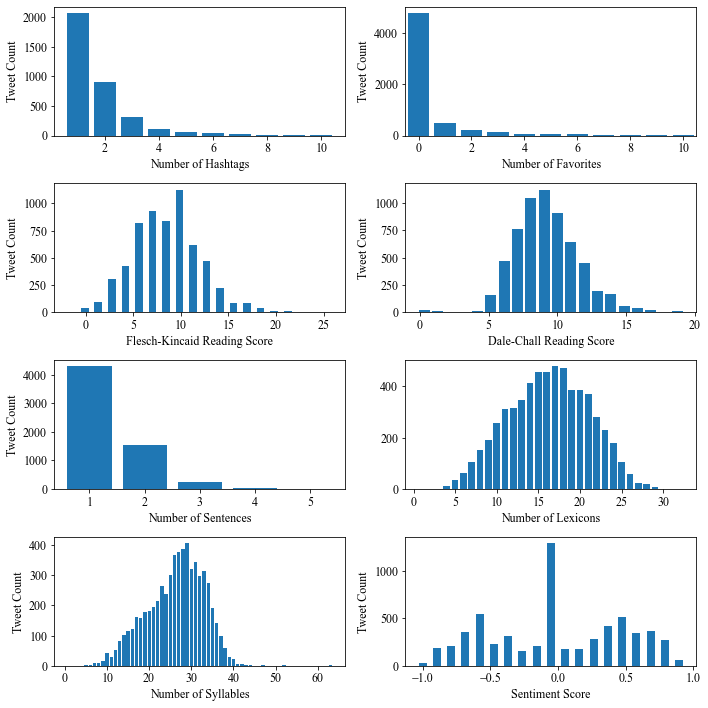

In [93]:
# Plot statistics of these measures
fig,ax = plt.subplots(4,2,figsize=(10,10))

# Hashtag Count
his = np.histogram(df_correlation['hashtag_num'],bins=range(1,max(df_correlation['hashtag_num'])+2))
ax[0][0].bar(his[1][:-1],his[0])
ax[0][0].set_xlabel('Number of Hashtags')
ax[0][0].set_ylabel('Tweet Count')

# Favorite Count
temp = df_correlation[df_correlation['favorite_count']<=10]['favorite_count'].astype(int)
his = np.histogram(temp,bins=range(0,max(temp)+2))
ax[0][1].bar(his[1][:-1],his[0])
ax[0][1].set_xlabel('Number of Favorites')
ax[0][1].set_ylabel('Tweet Count')
ax[0][1].set_xlim([-0.5,10.5])
ax[0][1].set_xticks(np.arange(0,11,2))

# Flesch-Kincaid Reading Score
his = np.histogram(df_correlation['flesch_kincaid'],bins=20)
ax[1][0].bar(his[1][:-1],his[0])
ax[1][0].set_xlabel('Flesch-Kincaid Reading Score')
ax[1][0].set_ylabel('Tweet Count')

# Dale-Chall Reading Score
his = np.histogram(df_correlation['dale_chall'],bins=20)
ax[1][1].bar(his[1][:-1],his[0])
ax[1][1].set_xlabel('Dale-Chall Reading Score')
ax[1][1].set_ylabel('Tweet Count')

# Sentence Count
his = np.histogram(df_correlation['sentence_count'],bins=range(1,max(df_correlation['sentence_count'])+2))
ax[2][0].bar(his[1][:-1],his[0])
ax[2][0].set_xlabel('Number of Sentences')
ax[2][0].set_ylabel('Tweet Count')

# Lexicon Count
his = np.histogram(df_correlation['lexicon_count'],bins=range(1,max(df_correlation['lexicon_count'])+2))
ax[2][1].bar(his[1][:-1],his[0])
ax[2][1].set_xlabel('Number of Lexicons')

# Syllable Count
his = np.histogram(df_correlation['syllable_count'],bins=range(1,max(df_correlation['syllable_count'])+2))
ax[3][0].bar(his[1][:-1],his[0])
ax[3][0].set_xlabel('Number of Syllables')
ax[3][0].set_ylabel('Tweet Count')

# Sentiment
his = np.histogram(df_correlation['sentiment'],bins=np.linspace(-1,1,20))
ax[3][1].bar(his[1][:-1],his[0],width=0.06)
ax[3][1].set_xlabel('Sentiment Score')
ax[3][1].set_ylabel('Tweet Count')

plt.tight_layout()

<AxesSubplot:>

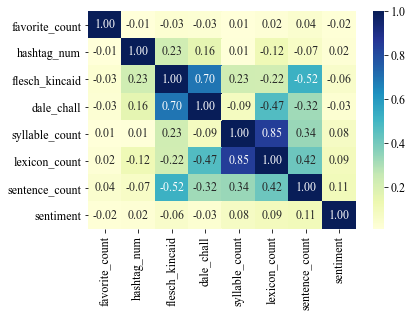

In [46]:
import seaborn as sns
df_correlation_corr = df_correlation.corr()
sns.heatmap(np.abs(df_correlation_corr),cmap="YlGnBu",annot=df_correlation_corr,fmt='.2f')

In [44]:
df_correlation_normalized = df_correlation.copy()
df_correlation_normalized['created_at'] = df_harvey_successful['created_at']
df_correlation_normalized = df_correlation_normalized.set_index('created_at')
df_correlation_normalized = df_correlation_normalized.groupby(pd.Grouper(freq='H')).agg('mean')
df_correlation_normalized = df_correlation_normalized.fillna(method='bfill')
output = widgets.Output()
unique_labels_transformed = list(df_correlation_normalized.columns)

def clicked(b):
    
    output.clear_output(wait=True)
    with output:
        category = filterdrop.value
        if category=='Select One...':
            pass
        else:
            fig,ax = plt.subplots(figsize=(15,5))
            ax.plot(df_correlation_normalized.index,df_correlation_normalized[category],label=category)
            ax.set_xlabel("Time",fontsize=15)
            ax.set_ylabel("Value",fontsize=15)
            plt.legend()
            plt.show()


filterdrop = widgets.Dropdown(
    options = ['Select One...']+list(unique_labels_transformed),
    description = "Property: ",
    disabled = False
)
filterdrop.observe(clicked)
display(filterdrop,output)

# for col in df_correlation_normalized.columns:
#     df_correlation_normalized[col]=(df_correlation_normalized[col]-min(df_correlation_normalized[col]))/\
#     (max(df_correlation_normalized[col])-min(df_correlation_normalized[col]))

    
# Draw a trend plot

Dropdown(description='Property: ', options=('Select One...', 'favorite_count', 'hashtag_num', 'flesch_kincaid'…

Output()

In [51]:
# There actually are a lot of noise in the trend plot. 
# How about performing a seasonal decomposition to actually see this better?

output_decompose = widgets.Output()
unique_labels_transformed = list(df_correlation_normalized.columns)

def clicked_decompose(b):
    
    output_decompose.clear_output(wait=True)
    with output_decompose:
        category = filterdrop_decompose.value
        if category=='Select One...':
            pass
        else:
            df_temp = df_correlation_normalized[category]
            if min(df_temp)<=0:
                df_temp = df_temp-min(df_temp)+0.01
            DecomposeResult = seasonal_decompose(df_temp,model='multiplicative')
            fig,ax = plt.subplots(4,1,figsize=(15,10),sharex='all')

            ax[0].plot(df_temp.index,DecomposeResult.observed)
            ax[0].set_ylabel("Observed",fontsize=15)
            ax[1].plot(df_temp.index,DecomposeResult.trend)
            ax[1].set_ylabel("Trend",fontsize=15)
            ax[2].plot(df_temp.index,DecomposeResult.seasonal)
            ax[2].set_ylabel("Seasonal",fontsize=15)
            ax[3].plot(df_temp.index,DecomposeResult.resid)
            ax[3].set_ylabel("Residual",fontsize=15)            
            ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
            ax[1].xaxis.set_tick_params(which='both', labelbottom=True)
            ax[2].xaxis.set_tick_params(which='both', labelbottom=True)
            plt.show()


filterdrop_decompose = widgets.Dropdown(
    options = ['Select One...']+list(unique_labels_transformed),
    description = "Property: ",
    disabled = False
)

filterdrop_decompose.observe(clicked_decompose)
display(filterdrop_decompose,output_decompose)

Dropdown(description='Property: ', options=('Select One...', 'favorite_count', 'hashtag_num', 'flesch_kincaid'…

Output()

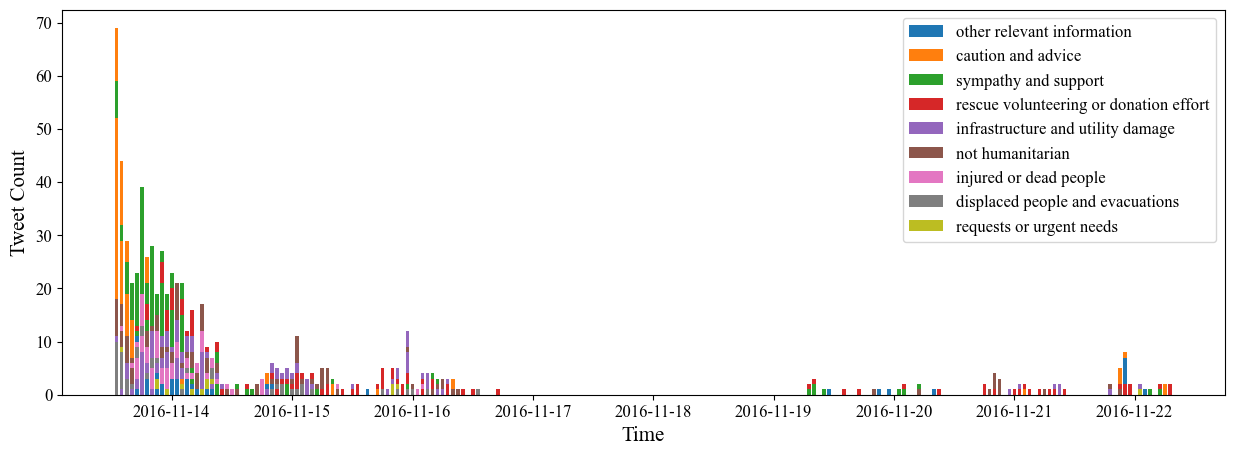

In [72]:
# Earthquake-related tweets should be presenting another distinct pattern. 
# E.g. there should be fewer warnings considering its unpredictability.
df_kaikoura = df[df['place'].str.startswith('kaikoura')]
df_kaikoura_successful = df_kaikoura[df_kaikoura['Response-Code']=='Successful']
df_kaikoura_successful = df_kaikoura_successful[df_kaikoura_successful['created_at'].dt.month==11]
df_kaikoura_successful_reset_index = df_kaikoura_successful.set_index('created_at')
df_kaikoura_agg = df_kaikoura_successful_reset_index.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
class_list = df_kaikoura_successful['class_label'].unique()
figure,ax = plt.subplots(figsize=(15,5))
agg_class_past = [0]*df_kaikoura_agg.shape[0]
for class_label in class_list:
    df_class = df_kaikoura_successful_reset_index[df_kaikoura_successful_reset_index['class_label']==class_label]
    df_class_agg = df_class.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Class Count'})
    df_class_agg = pd.merge(df_kaikoura_agg,df_class_agg,how='left',left_index=True,right_index=True).fillna(0)
    ax.bar(df_class_agg.index, df_class_agg['Tweet Class Count'], width=0.03, bottom=agg_class_past,label=class_label.replace('_',' '))
    agg_class_past=df_class_agg['Tweet Class Count']
ax.set_xlabel('Time',fontsize=15)
ax.set_ylabel('Tweet Count',fontsize=15)
plt.legend()

We can see VERY different trends for hurricane-harvey and earthquake-kaikoura. 

So, question: is there a way to **compare the similarity in trends** across disasters?

Referencing what we have learned in Data Mining II, we will use **Dynamic Time Warping** (DTW) to analyze the "time series distance".

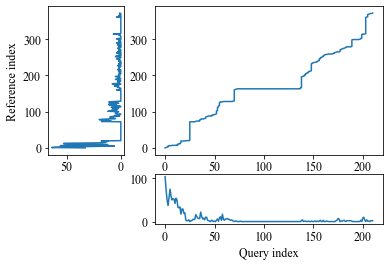

<AxesSubplot:>

In [94]:
# Create a time-series vector for DTW Analysis.
# Honestly I do not know how to manipulate labels, legends, etc. in this DTW package, so we might need manually add them.
def create_timevector(keyword):
    df_place = df[df['place'].str.startswith(keyword.lower().split()[0])]
    df_place_successful = df_place[df_place['Response-Code']=='Successful']
    assert df_place_successful.shape[0]>0
    if keyword.lower().split()[0]=='kaikoura':
        df_place_successful = df_place_successful[df_place_successful['created_at'].dt.month==11]
    df_place_successful_reset_index = df_place_successful.set_index('created_at')
    df_place_agg = df_place_successful_reset_index.groupby(pd.Grouper(freq='H')).agg({'id_str':'count'}).rename(columns={'id_str':'Tweet Count'})
    index = pd.date_range(df_place_agg.index[0], df_place_agg.index[-1], freq='H')
    df_place_agg = pd.DataFrame(index=index).merge(df_place_agg,how='left',left_index=True,right_index=True).fillna(0)
    return df_place_agg

df_kaikoura_timeseries = create_timevector('kaikoura')
df_puebla_timeseries = create_timevector('puebla')

alignment = dtw(np.array(df_kaikoura_timeseries['Tweet Count'])/1, np.array(df_puebla_timeseries['Tweet Count'])/1,keep_internals=True)

alignment.plot(type="threeway")

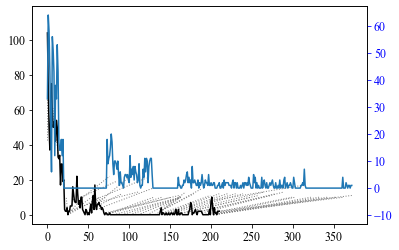

<AxesSubplot:>

In [95]:
alignment.plot(type='twoway',offset=10)

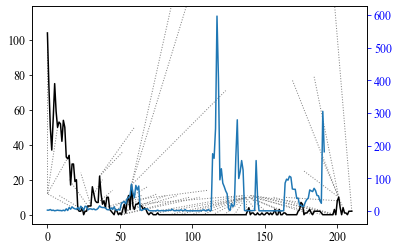

<AxesSubplot:>

In [96]:
# On the other hand, Harvey (Hurricane) and Kaikoura (Earthquake) do not match.
df_harvey_timeseries = create_timevector('harvey')
alignment = dtw(np.array(df_kaikoura_timeseries['Tweet Count'])/1, np.array(df_harvey_timeseries['Tweet Count'])/1,keep_internals=True)
alignment.plot(type='twoway',offset=10)

In [137]:
disaster_list = ['California Wildfires','Canada Wildfires','Dorian Hurricane','Florence Hurricane','Harvey Hurricane',
                'Irma Hurricane','Maria Hurricane','Matthew Hurricane','Ecuador Earthquake','Italy Earthquake',
                 'Kaikoura Earthquake','Pakistan Earthquake','Puebla Earthquake','Kerala Floods','Midwestern US Floods','Srilanka Floods','Idai Cyclone']

df_timeseries = [create_timevector(string) for string in disaster_list]
distance_matrix = np.zeros((len(disaster_list),len(disaster_list)))
for i in range(len(disaster_list)-1):
    for j in range(i+1,len(disaster_list)):
        result = dtw(np.array(df_timeseries[i]['Tweet Count'])/1, np.array(df_timeseries[j]['Tweet Count'])/1,keep_internals=True).distance
        distance_matrix[i,j] = result
        distance_matrix[j,i] = result

distance_matrix /= np.max(distance_matrix)

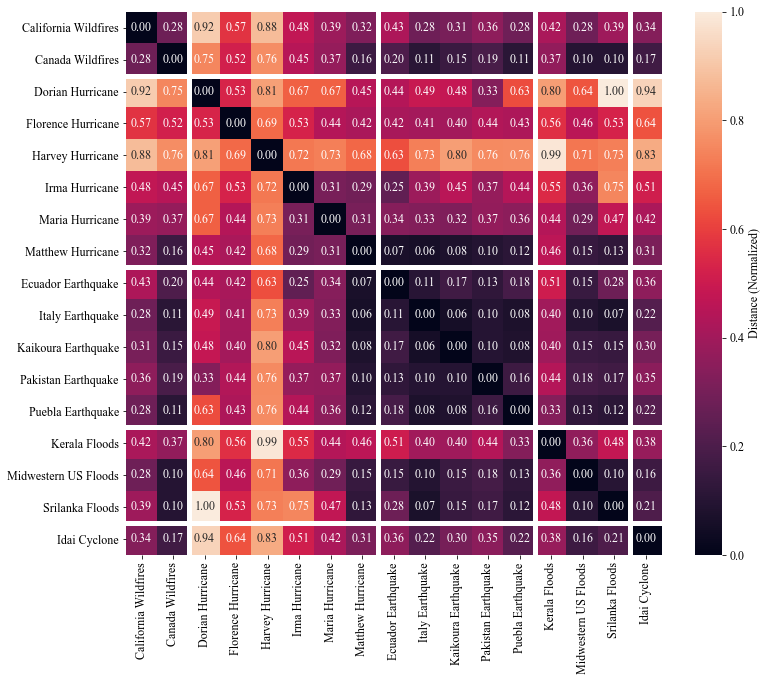

In [139]:
# See the similarity among different disasters.
fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(distance_matrix,ax=ax,annot=True,fmt='.2f',cbar_kws={'label': 'Distance (Normalized)'})
ax.set_xticks(np.arange(len(disaster_list))+0.5)
ax.set_yticks(np.arange(len(disaster_list))+0.5)
ax.set_xticklabels(disaster_list,rotation=90)
ax.set_yticklabels(disaster_list,rotation=0)
ax.plot([2,2],[0,17],color='white',linewidth=5)
ax.plot([0,17],[2,2],color='white',linewidth=5)
ax.plot([8,8],[0,17],color='white',linewidth=5)
ax.plot([0,17],[8,8],color='white',linewidth=5)
ax.plot([13,13],[0,17],color='white',linewidth=5)
ax.plot([0,17],[13,13],color='white',linewidth=5)
ax.plot([16,16],[0,17],color='white',linewidth=5)
ax.plot([0,17],[16,16],color='white',linewidth=5)